In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import laws_ai.db as db

db = db.base()

In [2]:
texts = db.published_laws.aggregate(
    [
        {
            '$lookup':
            {
                'from': "texts",
                'localField': "text",
                'foreignField': "_id",
                'as': "texts"
            }
        },
        {
            '$lookup':
            {
                'from': "laws",
                'localField': "law",
                'foreignField': "_id",
                'as': "laws"
            }
        },
        {
           '$unwind': "$laws"
        },
        {
           '$unwind': "$texts"
        },
          {
            "$project": {
              "_id": 1,
              "date": 1,  
              "texts.text": 1, 
              "laws.authors": 1, 
              "laws.law_code": 1, 
            }
          }
    ]
)
dados = []
for i in texts:
    text =  i["texts"]["text"]
    author = i["laws"]["authors"][0]
    law_code = i["laws"]["law_code"]
    date = pd.to_datetime( i["date"],infer_datetime_format=True)
    dados.append({'date': date, 'law_code': law_code, 'text': text, 'author': author})

dataset = pd.DataFrame(list(dados))
df = dataset

## Análise Exploratória

In [3]:
df = dataset
size1 = len(df)
print("Size before clean: ", size1) 

df = df[~df['text'].str.contains("O PRESIDENTE DA REPÚBLICA")]
df = df[~df['text'].str.contains("O VICE–PRESIDENTE DA REPÚBLICA")]

size2 = len(df)
print("Size after clean: ", len(df), ". Redução de ", (100 - int((size2 * 100) / size1)), "% dos dados")


Size before clean:  71011
Size after clean:  69286 . Redução de  3 % dos dados


In [4]:
print("Sample (3):")
print(df.sample(n=3, random_state=1))

Sample (3):
            date law_code                                               text  \
41716 2018-01-05   L13595  Art. 9º-E. Atendidas as disposições desta Lei ...   
36247 2009-08-12   L12017   VI – ao pagamento de benefícios mensais às pe...   
66794        NaT   L12213  c) entregar a declaração fora do prazo; (Inclu...   

                       author  
41716            MICHEL TEMER  
36247  LUIZ INACIO LULA SILVA  
66794  LUIZ INACIO LULA SILVA  


## Prepara o texto

In [5]:
import nltk
from string import punctuation
import re
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
stop_words = set(stopwords + list(punctuation))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/developer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def df_clean_text(df):
    text = df['clean_text']
    text = " ".join(text.split())
    text = re.sub('<[^>]+>', '', text)
    text = text.split("(function")[0]
    text = text.lower()
    text = [palavra for palavra in text.split() if palavra not in stop_words]
    text = " ".join(text)
    return text


In [7]:
def clean_text(text):
    text = " ".join(text.split())
    text = re.sub('<[^>]+>', '', text)
    text = text.split("(function")[0]
    text = text.lower()
    text = [palavra for palavra in text.split() if palavra not in stop_words]
    text = " ".join(text)
    return text


In [8]:
def count_text(text):
    text_splited = text.split(' ')
    fdist1 = nltk.FreqDist(text_splited) 
    return fdist1


In [9]:
def categorizar(text):
    text_array = text.split()
    if "icms" in text_array:
        return "icms"
    if "is" in text_array:
        return "is"
    if "cofins" in text_array:
        return "pis cofins"
    if "pasep" in text_array:
        return "pis pasep"
    if "ipi" in text_array:
        return "ipi"
    if "iss" in text_array:
        return "iss"
    if "itr" in text_array:
        return "itr" 
    if "ie" in text_array:
        return "ie" 
    if "iof" in text_array:
        return "iof"
    if "irpj" in text_array:
        return "irpj"
    if "irpf" in text_array:
        return "irpf"
    if "cofins" in text_array:
        return "cofins"
    if "cide" in text_array:
        return "cide"
    if "csll" in text_array:
        return "csll" 
    if "fgts" in text_array:
        return "fgts"

In [10]:
df['clean_text'] = df['text'].apply(clean_text)
df['cat'] = df['clean_text'].apply(categorizar)
df['n_words'] = df['clean_text'].apply(lambda x: len(x.split(' ')))

In [11]:
texts = df['clean_text'].str.split()
vocab = Counter()

for i in texts:
    for w in i:
        vocab[w]+=1

print("Total words:", len(vocab))

Total words: 67965


In [12]:
df_categorized = df
df_categorized = df_categorized.mask(df["cat"].eq(None)).dropna()
df_categorized

,date,law_code,text,author,clean_text,cat,n_words
131,2008-10-06,L11793,§ 1o O rateio entre os Municípios das parcelas...,LUIZ INACIO LULA SILVA,§ 1o rateio municípios parcelas trata inciso i...,icms,26
132,2008-10-06,L11793,§ 2o O rateio entre os Municípios das parcelas...,LUIZ INACIO LULA SILVA,§ 2o rateio municípios parcelas trata inciso i...,icms,26
1292,1986-11-21,Del2290compilado,"Art. 12. Os saldos das cadernetas de poupança,...",JOSE SARNEY,"art. 12. saldos cadernetas poupança, bem fundo...",fgts,91
2184,2004-04-30,L10.865compilado,"II - o valor pago, creditado, entregue, empre...",LUIZ INACIO LULA SILVA,"ii valor pago, creditado, entregue, empregado ...",iss,30
2298,2004-04-30,L10.865compilado,Art. 14. As normas relativas à suspensão do pa...,LUIZ INACIO LULA SILVA,art. 14. normas relativas suspensão pagamento ...,ipi,22
...,...,...,...,...,...,...,...
42177,2004-08-11,L10.934compilado,IX - a participação do Tesouro Nacional no pa...,LUIZ INACIO LULA SILVA,ix participação tesouro nacional pagamento exp...,fgts,21
53522,2010-08-09,L12309,XI - apresentação pela entidade de certidão ne...,LUIZ INACIO LULA SILVA,xi apresentação entidade certidão negativa cer...,fgts,39
56228,2009-03-04,L11909,Art. 4o Caberá ao Ministério de Minas e Energi...,LUIZ INACIO LULA SILVA,art. 4o caberá ministério minas energia: i pro...,cide,108
63776,1969-03-05,Del0491,Art. 5º É assegurada a manutenção e utilização...,A COSTA E SILVA,art. 5º assegurada manutenção utilização crédi...,ipi,139


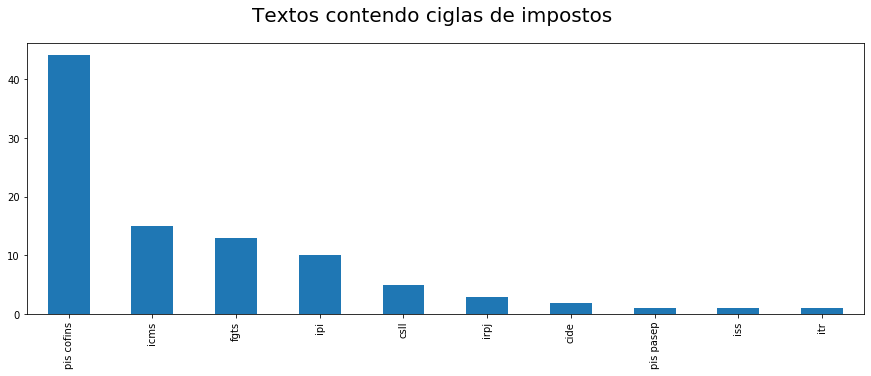

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
fig = plt.figure()
fig.suptitle('Textos contendo ciglas de impostos', fontsize=20)
cat_values = df_categorized['cat'].value_counts()
cat_values.plot(kind='bar', figsize=(15, 5)) 


Esta é uma simples aplicação, o objetivo aqui foi apena identificar referências aos impostos nos textos.